Imran Muhammad, Olga Kellert, and Carlos Gómez-Rodríguez. "A Syntax-Injected Approach for Faster and More Accurate Sentiment Analysis." arXiv preprint arXiv:2406.15163 (2024). The preprint version is available on arXiv: URL: https://arxiv.org/html/2406.15163v1

In [112]:
!pip install stanza

In [1]:
from utilities import *
import transformers
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

from src.models.deps_tree import D_Tree
from src.models.deps_label import D_Label
from src.utils.constants import D_ROOT_HEAD, D_NULLHEAD, D_ROOT_REL, D_POSROOT, D_EMPTYREL, D_2P_GREED, D_2P_PROP
#from src.utils.constants import D_ROOT_HEAD
from src.encs.enc_deps import *
from src.utils.constants import *
from src.models.linearized_tree import LinearizedTree

2024-06-13 16:04:10.402057: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 16:04:10.440408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 16:04:11.258282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import io
import spacy
import os
import time
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
from statistics import mean
import stanza
stanza.download('es')
nlp = stanza.Pipeline('es')

2024-06-13 16:04:12 INFO: Downloading default packages for language: es (Spanish) ...
2024-06-13 16:04:13 INFO: File exists: /home/imran/stanza_resources/es/default.zip
2024-06-13 16:04:17 INFO: Finished downloading models and saved to /home/imran/stanza_resources.
2024-06-13 16:04:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-13 16:04:18 INFO: Loading these models for language: es (Spanish):
| Processor    | Package         |
----------------------------------
| tokenize     | ancora          |
| mwt          | ancora          |
| pos          | ancora_charlm   |
| lemma        | ancora_nocharlm |
| constituency | combined_charlm |
| depparse     | ancora_charlm   |
| sentiment    | tass2020        |
| ner          | conll02         |

2024-06-13 16:04:18 INFO: Using device: cuda
2024-06-13 16:04:18 INFO: Loading: tokenize
2024-06-13 16:04:18 INFO: Loading: mwt
2024-06-13 16:04:18 INFO: Loading: pos
2024-06-13 16:04:18 INFO: Loading: lemma
2024-06-13 16:04:18 INFO: Loading: constituency
2024-06-13 16:04:19 INFO: Loading: depparse
2024-06-13 16:04:19 INFO: Loading: sentiment
2024-06-13 16:04:19 INFO: Loading: ner
2024-06-13 16:04:20 INFO: Done loading processors!


In [4]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,pos,mwt,lemma,depparse')

2024-06-13 16:04:20 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-13 16:04:20 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |
| depparse  | ancora_charlm   |

2024-06-13 16:04:20 INFO: Using device: cuda
2024-06-13 16:04:20 INFO: Loading: tokenize
2024-06-13 16:04:20 INFO: Loading: mwt
2024-06-13 16:04:20 INFO: Loading: pos
2024-06-13 16:04:21 INFO: Loading: lemma
2024-06-13 16:04:21 INFO: Loading: depparse
2024-06-13 16:04:21 INFO: Done loading processors!


Process the dictionaries


In [5]:
# def populateDict(fileLocation):
#     dic={}
#     f = open(fileLocation, encoding='latin-1')
#     for line in f:
#         (key,value) = line.split()
#         dic[key]=int(value.strip())
#     return dic

In [6]:
def populateDict(filename):
    dic = {}
    encodings = ['utf-8', 'latin-1', 'cp1252']
    for encoding in encodings:
        try:
            with open(filename, 'r', encoding=encoding) as file:
                for line in file:
                    try:
                        #(key,value) = line.split()
                        #dct[key]=float(value.strip())
                        word, value = line.strip().split('\t')
                        dic[word] = float(value)
                    except ValueError:
                        print("Error parsing line:", line)
            return dic
        except UnicodeDecodeError:
            print(f"Failed to decode using {encoding} encoding")
    print("Failed to decode the file using any of the specified encodings")
    return None

In [ ]:
Dict = "Dict1" #Options ["Dict1", "Dict2", "Dict3", "Dict4"]
mode = "Stanza" #Options ["Model", "Stanza"]

In [ ]:
# Dict1 - SO-CAL
if(Dict == "Dict1"):
    dAdj = populateDict('../sentiment-dictionaries/spanish/so-cal/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/spanish/so-cal/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/spanish/so-cal/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/spanish/so-cal/verb.txt')

# Dict2 - Merged (SO-CAL + VADER)
elif(Dict == "Dict2"):
    dAdj = populateDict('../sentiment-dictionaries/spanish/vader/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/spanish/vader/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/spanish/vader/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/spanish/vader/verb.txt')

# Dict3 - Rest-Mex Only
elif(Dict == "Dict3"):
    dAdj = populateDict('../sentiment-dictionaries/spanish/Rest-Mex-Only/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/spanish/Rest-Mex-Only/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/spanish/Rest-Mex-Only/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/spanish/Rest-Mex-Only/verb.txt')

# Dict4 - Merged (Rest-Mex + SO-CAL + VADER)
elif(Dict == "Dict4"):
    dAdj = populateDict('../sentiment-dictionaries/spanish/Rest-Mex/adj.txt')
    dAdv = populateDict('../sentiment-dictionaries/spanish/Rest-Mex/adv.txt')
    dNoun = populateDict('../sentiment-dictionaries/spanish/Rest-Mex/noun.txt')
    dVerb = populateDict('../sentiment-dictionaries/spanish/Rest-Mex/verb.txt')

# Sentdicts
sentdicts={"ADV": dAdv, "ADJ": dAdj, "NOUN": dNoun, "VERB": dVerb}

In [10]:
lstNeg =['nadie','tampoco','no','ez','non','no','nunca','não','nada','ni','nunca','ningun','ninguno','ninguna','nisiquiera', "sin"]###new list of negation elements


In [11]:
# Dictionary of modifiers/intensifiers in Spanish
dInt = populateDict('../sentiment-dictionaries/spanish/intensifiers.txt')

In [12]:
#updated on May 14
dictionaries = [dAdj, dNoun, dVerb, dAdv] # 14.5 important!!! This code snippet makes sure that intensifiers do not match sentiment words

# Iterate through each dictionary
for d in dictionaries:
    # Iterate through the keys of dInt
    for key in dInt.keys():
        # Check if the key exists in the current dictionary
        if key in d:
            # Delete the entry from the current dictionary
            del d[key]

In [13]:
max(dAdv.values())

5.0

In [14]:
min(dAdv.values())

-5.0

In [15]:
max(dAdj.values())

5.0

In [16]:
min(dAdj.values())

-5.0

In [17]:
if(mode == 'Model'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    tokenizer = AutoTokenizer.from_pretrained("dccuchile/distilbert-base-spanish-uncased")
    model = AutoModelForTokenClassification.from_pretrained("../parsers/models/rel-distilbert-es/model")
elif(mode == "Stanza"):
    pass

cuda


In [18]:
### analysing a string (=sent) with Stanza
def createDic(sent):
    doc = nlp(sent)
    dicts=doc.to_dict()
    return dicts # lists of sentences where each sentence is split into words and each word has a dictionary

def createDicModel(text, spacy_data):
    try:
        tokens_with_spacy = spacy_data['tokens']
        if tokens_with_spacy[-1] == '\n':
            tokens_with_spacy = tokens_with_spacy[:-1]

        tokenized_text = pre_tokenized_text(tokens_with_spacy)
        # Example pre-tokenized text/data
        #tokenized_text = ["[CLS]", 'I', 'do', "n't", 'eat', 'very', 'much', 'pieces', 'of', 'chocolate', '.', "[SEP]"]

        # Convert tokens to input IDs using the tokenizer
        input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)

        # Create input tensors
        input_ids = torch.tensor(input_ids).unsqueeze(0)  # Add a batch dimension

        with torch.no_grad():
            #logits = model(**inputs).logits
            logits = model(input_ids).logits

            predictions = torch.argmax(logits, dim=2)
            predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0][1:-1]]

        words = tokens_with_spacy
        postags = spacy_data['postags']
        if postags[-1] == 'SPACE':
            postags = postags[:-1]
        labels = []
        for p in predicted_token_class:
            if(p != '[CLS]' and p != '[SEP]'):
                labels.append(D_Label.from_string(p, sep="_"))
        lin_tree = LinearizedTree(words=words, postags=postags,
                    additional_feats=[], labels=labels, n_feats=0)

        encoder = D_NaiveRelativeEncoding(separator="_", hang_from_root=True)
        dec_tree = encoder.decode(lin_tree)
        dec_tree.postprocess_tree(search_root_strat=D_ROOT_HEAD, allow_multi_roots=False)
        dec_tree = str(dec_tree)

        return [tree2dic_optim(dec_tree, spacy_data['lemmas'])]
    except Exception as e:
        print("Model Inference Error: " + str(e))

In [22]:
def FilterNonLemmaWords(Sentence): # this function deletes problematic lemmas like Spanish: hacerlo
    FilteredSentence=[word for word in Sentence if 'lemma' in word.keys()]
    return (FilteredSentence)

In [23]:
def CreateDefaultElementType(Sentence): # assigns to each lemma a default element type 'ord'
    for i in range(len(Sentence)):
        Sentence[i]['elementType'] = 'ord'
    return (Sentence)

In [24]:
# Set element score from Sentiment dictionaries
def GetElementScore(Sentence):
    for i in range(len(Sentence)):
        lem = Sentence[i]['lemma']
        upos = Sentence[i]['upos']

        if upos == 'ADJ' and lem in dAdj.keys():
            Sentence[i]['elementScore']=dAdj[lem]
        elif upos == 'ADV' and lem in dAdv.keys():
            Sentence[i]['elementScore']=dAdv[lem]
        elif upos == 'VERB' and lem in dVerb.keys():
            Sentence[i]['elementScore']=dVerb[lem]
        elif upos == 'NOUN' and lem in dNoun.keys():
            Sentence[i]['elementScore']=dNoun[lem]
        else:
            Sentence[i]['elementScore']='none'
    return Sentence

In [25]:
def InitializeSentimentScore(Sentence): # default is a Sentiment Score
    for i in range(len(Sentence)):
        Sentence[i]['SentimentScore']='none'
    return Sentence

In [26]:
### Creating dctChild dictionary: key= headid, value= a list of childrenids
def getChildParentDicts(dct):
    dctChild       = {} ## for now, this dictionary is important
    dctParent      = {}
    dctBeforeToken = {}

    for dicVal in dct:
        #print(dicVal)
        elementID          = dicVal['id']
        elementHead        = dicVal['head']
        elementLemma       = dicVal['lemma']

        #print(type(dct))
        if(elementID != 1 ):
            eleBeforeDic = dct[int(elementID)-2]
            elementBeforLemma = eleBeforeDic['lemma']
            #print(elementID, elementLemma, eleBeforeDic, eleBeforeDic['lemma'], elementBeforLemma)
        else:
            elementBeforLemma = "-"

        # dic parent is done
        dctParent[elementID] = elementHead
        dctBeforeToken[elementLemma] =elementBeforLemma

        if elementHead not in dctChild.keys():
            dctChild[elementHead] =[]

        # Adding to the parent node (Elements and ElementsLemma)
        dctChild[elementHead].append(elementID)

    # working on Sibling dictionary
    dctSibling = {}

    # Giviing some default values
    for key in dctParent.keys():
        dctSibling[key]=[]
    for key in dctChild.keys():
        childList = dctChild[key]
        #print(childList)
        for chld in childList:
          #print("Child is: ", chld)
          dctSibling[chld] = [x for x in childList if x != chld]
    return dctChild, dctParent, dctSibling, dctBeforeToken

In [27]:
#### definining the ORDER of key-value pairs from dctChild, which equal tree branches in a dependency tree. The order follows from branches at the bottom that are simple branches (sb) to complex branches (cb), e.g. [a [very good]-sb service]-cb
def calcbranchorder(dctChild):
    #print("dctChild.keys are", list(dctChild.keys()))
    if list(dctChild.keys())==[0]:
        calcheads=[0]
        #print("only one word")
    else:
        allheads=list(dctChild.keys())
        calcheads=[]
        children=dctChild[0]
        nextchildren=[]
        numchildren=len(children)
        #print("numchildren is", numchildren)
        while numchildren > 0:
            nextchildren=[]
            #print('numchildren = ', numchildren)
            for child in children:
                #print('child = ', child)
                if child in allheads:
                    #print('headchild = ', child)
                    calcheads.append(child)
                    nextchildren = nextchildren + dctChild[child]
                    #print('calcheads = ', calcheads)
                    #print('nextchildren = ', nextchildren)
            children=nextchildren
            numchildren=len(children)
        calcheads.reverse()
    #print('branch order = ', calcheads)
    return calcheads

Compute the Sentence Score

In [28]:
################################ to deal with conjunction ############
# this code snippet is a definition that takes a list of word dictionaries (=dct) and spits out a modified dct with updated elementScore that depends on sentiment words being modified by elements like intensification, negation, adversative modifiers.

from pickle import TRUE
def calcbranch(dct, headId,childIds):
    #dct is a list of word dictionaries like Sentence
    lstchildren=[dct[childId-1]["text"] + "({},{})".format(childId, dct[childId-1]["deprel"]) for childId in childIds]
    #print("head: {}({}), children: {}".format(dct[headId-1]["text"], headId, lstchildren) )
####finding relevant elements in each branch
    a=0
    b=0
    c=0
    neg=0
    p=0
    pvalue=0.25
    negvalue=-4
    Negstat=False
    fmodstat=False
    lexmodstat=False
    conjmodstat=False
    lexstat=False
    lstcntchildren=[]
    lstmodification=[]
    lstnegation=[]
    PrintList=[]
    
    # default outputs
    HeadOutput=[]
    NegOutput=[]
    ModOutput=[]

    #### starting with children of the branch
    PrintList.append('Number of Children: {}'.format(len(childIds)))
    for i in range(len(childIds)):
        childId=childIds[i]
        lemma=dct[childId-1]["lemma"]
        text=dct[childId-1]["text"]
        pos=dct[childId-1]["upos"]#
        deprel=dct[childId-1]["deprel"] # head, amod, nmod, mod in deprel
        elementScore=dct[childId-1]["elementScore"]
        if dct[childId-1]["SentimentScore"]!='none':
            SentimentScore=dct[childId-1]["SentimentScore"]
        else:
            SentimentScore=elementScore
        #lstchildren[i]=lstchildren[i] + "({})".format(deprel)

        if lemma in lstNeg: # find negation
            ### Child cannot be a head. ###
            Negstat=True
            neg=negvalue
            lstchildren[i]=lstchildren[i] + "({})".format("N")
            dct[childId-1]['elementType']='neg'
            #print("negation token is: ", text, "negation childid is: ", childId, "the negation value is: ", neg) #information for the demo
            PrintList.append("Child{}: '{}'({}), Neg={}".format(i, text, childId, neg)) # important for the demo
            NegOutput=[text,neg]
        elif text == 'un' and pos=="DET" and deprel == 'advmod': # 31.5 accounting for "un poco as in un poco triste or ofrece un poco."
            fmodstat = True
            b=-0.3
            lstchildren[i]=lstchildren[i] + "(un poco={})".format(b)
            ModOutput=[text,b]
        elif lemma in dInt.keys() and ('mod' in deprel or 'det' in deprel or 'obj' in deprel):# new added 26 May,  find intensification
            ### Child cannot be a head. ###
            fmodstat = True
            PrevExists=(childId-2) >= 0
            NextExists=childId <= len(dct)-1
            if PrevExists:
                PrevIsInt=dct[childId - 2]["lemma"] in dInt.keys()
                PrevIsNeg=dct[childId - 2]["lemma"] in lstNeg
                PrevIsHead=dct[childId - 2]["head"]==dct[childId-1]["id"]
            else:
                PrevIsInt=False
                PrevIsNeg=False
                PrevIsHead=False
            if NextExists:
                NextIsInt=dct[childId]["lemma"] in dInt.keys()
            else:
                NextIsInt=False
            if PrevIsInt==False and NextIsInt==False: # single intensifier found, e.g. a VERY good service
                if PrevIsNeg and PrevIsHead: # looking for head negation of a single intensifier, e.g. not many problems (Stanza analyses not as a head of many)
                    if dInt[lemma] >0:
                        b= -abs(dInt[lemma])
                    if dInt[lemma] <0:
                        b = abs(dInt[lemma])
                else:
                    b = dInt[lemma]
                #print("{}single modifier={}({}), b={}".format(indent, text, childId, b)) ###new 23.5
                PrintList.append("single modifier={}({}), b={}".format(text, childId, b)) ###new 23.5
                PrintList.append("Child{}: '{}'({}), 1b={}".format(i, text, childId, b))
                lstchildren[i]=lstchildren[i] + "(1b={})".format(b)
                ModOutput=[text,b]
            elif PrevIsInt: #double modifier found, e.g. little bit, very small, etc.
                lemma2=dct[childId - 2]["lemma"]
                fmodscore=dInt[lemma]*(1+dInt[lemma2]) # a compound b or 2b
                b=fmodscore
                #print("double modifier is:", text, "childid is: ", childId, "the value of double modifier is: ",  b) ###new 22.5
                PrintList.append("double modifier={}({}), b={}".format(text, childId, b)) ###new 23.5, double modifier
                PrintList.append("Child{}: '{}'({}), 2b={}".format(i, text, childId, b))
                lstchildren[i]=lstchildren[i] + "(2b={})".format(b)
                ModOutput=["{}, {}".format(dct[childId - 2]["text"], text), b]
            else:
                PrintList.append("Child{}: '{}'({}), first part of 2b={}".format(i, text, childId, b))
                lstchildren[i]=lstchildren[i] + "(2b={})".format(b)
        #elif pos in sentdicts.keys(): # used before 1.6., only processes it if lexmodstat is not satisfied
        elif (lemma in sentdicts.keys() or SentimentScore!='none') and 'cl' not in deprel and 'conj' not in deprel: # children are neither adj, verbs, nouns or adverbs, but pronouns with a SentimenSscore
            lexmodstat=True
            a=SentimentScore
            lstchildren[i]=lstchildren[i] + "(a={})".format(SentimentScore)
              #PrintList.append("Child{}: '{}'({}), elementScore={}, SentimentScore, a={}".format(i, text, childId, elementScore, SentimentScore))
        elif (lemma in sentdicts.keys() or SentimentScore!='none') and ('cl' in deprel or 'conj' in deprel):
            conjmodstat=True
            c=SentimentScore
            lstchildren[i]=lstchildren[i] + "(c={})".format(SentimentScore)
        elif lemma in ['pero', 'obstante', 'sino', 'aunque', 'malgrado']:
            ### Child cannot be a head. ###
            p=pvalue
            lstchildren[i]=lstchildren[i] + "(p={})".format(p)
            #print("but is present and has the value of: ", p) # for the demo
            #PrintList.append("{} is present, p=".format(lemma, p)) # for the demo
            PrintList.append("Child{}: '{}'({}), p={}".format(i, text, childId, p))
        else:
            lstchildren[i]=lstchildren[i] + "({}={})".format(pos,SentimentScore)
            PrintList.append("Child{}: '{}'({})".format(i, text, childId))
        #print("child: ", childId, text, elementScore)
    PrintList.append("Children-derived score elements: a={}, c={}, b={}, neg={}, p={}".format(a, c, b, neg, p))
######################################################################################################################################
####continuing with parents/heads of the branch ###
    lemma=dct[headId-1]["lemma"]
    pos=dct[headId-1]["upos"]
    deprel= dct[headId-1]["deprel"]
    text= dct[headId-1]["text"]
    #headmodstat= "mod" in deprel or 'conj' in deprel
    headmodstat= "mod" in deprel
    #headmodstat= "mod" in deprel or 'DET' in 'upos' #new
    headscore="none"
    headsentimentscore='none'
    childp=p
    head_a=0
    head_b=0
    head_neg=0
    head_p=0
    calc_a, calc_b, calc_neg, calc_p = 0, 0, 0, 0
    words_to_match = ["barbaridad", "par", "montón"]
    #deprel_to_match = ["advmod", "obj"]
    lstheads=[]

    if lemma== "nada":
        head_neg=negvalue
        headsentimentscore=(a * (1+b)  + (np.sign(a*(1+b)))* head_neg)*(1+p) # new update on 3rd of June
        dct[headId-1]["SentimentScore"]= headsentimentscore #new
        PrintList.append("Head: '{}'({}), 'nada'={}, SentimentScore={}".format(text, headId, head_neg, headsentimentscore))
        lstheads.append([text,head_neg, headsentimentscore])
    elif lemma in words_to_match and pos =="NOUN":
        fmodscore= dInt[lemma]
        head_b=fmodscore
        fmodstat=True
        if True: #all([(type(x) is int) or (type(x) is float) for x in [a, head_b, p, neg]]):
            headsentimentscore=(a * (1+head_b)  + (np.sign(a*(1+head_b)))* neg)*(1+p) # new 25.5
            #headsentimentscore=(childsentimentscore * (1+head_b)  + (np.sign(childsentimentscore*(1+head_b)))* neg)*(1+p)# new 26.5
            dct[headId-1]["SentimentScore"]= headsentimentscore #new
            PrintList.append("Head: '{}'({}), head intensifier, b={}, SentimentScore={}".format(text, headId, head_b, headsentimentscore))
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
        else:
            PrintList.append("Head: '{}'({}), a, b, p or neg is not a number, SentimentScore={}".format(text, headId, headsentimentscore))
            calc_a, calc_b, calc_neg, calc_p = a, head_b, neg, p
    elif lexmodstat and conjmodstat: # if one of the children is a lexical head, then do the calculation of headsentimentscore.
        if True: #all([(type(x) is int) or (type(x) is float) for x in [a, b, p, neg]]):
            calc_a, calc_b, calc_neg, calc_p = a, b, neg, p
            headsentimentscore=np.mean([((a * (1+b)  + (np.sign(a*(1+b)))* neg)*(1+p)), c]) # new 3.6.
            #headsentimentscore=(childsentimentscore * (1+b)  + (np.sign(childsentimentscore*(1+b)))* neg)*(1+p) # 26.5
            dct[headId-1]["SentimentScore"]= headsentimentscore # the head gets the polarity score of the child
            PrintList.append("Head: '{}'({}), child is a sentiment word with a conjunction, a={},c={}, SentimentScore={}".format(text, headId, a, c, headsentimentscore)) # 25.5.
            #PrintList.append("Head inheriting Childfeatures: '{}'({}), childsentimentscore={}, SentimentScore={}".format(text, headId, childsentimentscore, headsentimentscore)) # 26.5.
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
        else:
            PrintList.append("Head: '{}'({}), a, b, p or neg is not a number, SentimentScore={}".format(text, headId, a, headsentimentscore))
    elif lexmodstat and conjmodstat!=True: # if one of the children is a lexical head, then do the calculation of headsentimentscore.
        if True: #all([(type(x) is int) or (type(x) is float) for x in [a, b, p, neg]]):
            calc_a, calc_b, calc_neg, calc_p = a, b, neg, p
            headsentimentscore=(a * (1+b)  + (np.sign(a*(1+b)))* neg)*(1+p)#25.5.
            #headsentimentscore=(childsentimentscore * (1+b)  + (np.sign(childsentimentscore*(1+b)))* neg)*(1+p) # 26.5
            dct[headId-1]["SentimentScore"]= headsentimentscore # the head gets the polarity score of the child
            PrintList.append("Head: '{}'({}), child is a sentiment word, a={}, SentimentScore={}".format(text, headId, a, headsentimentscore)) # 25.5.
            #PrintList.append("Head inheriting Childfeatures: '{}'({}), childsentimentscore={}, SentimentScore={}".format(text, headId, childsentimentscore, headsentimentscore)) # 26.5.
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
        else:
            PrintList.append("Head: '{}'({}), a, b, p or neg is not a number, SentimentScore={}".format(text, headId, a, headsentimentscore))
    elif pos in sentdicts.keys() and conjmodstat!=True: #only processes if lexmodstat (=child has a sentimentscore) is not satisfied
        dsent= sentdicts[pos]
        if lemma in dsent.keys():
            headscore=dsent[lemma]
            head_a=dsent[lemma]
            headsentimentscore=(head_a * (1+b)  + (np.sign(head_a*(1+b)))* neg)*(1+p)
            PrintList.append("Head: '{}'({}), head is a sentiment word, head_a={}, SentimentScore={}".format(text, headId, head_a, headsentimentscore))
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
            dct[headId-1]["SentimentScore"]= headsentimentscore
           
    elif pos in sentdicts.keys() and conjmodstat: #only processes if lexmodstat (=child has a sentimentscore) is not satisfied
        dsent= sentdicts[pos]
        if lemma in dsent.keys(): #or SentimentScore!='none':
            headscore=dsent[lemma]
            head_a=dsent[lemma]
            headsentimentscore=np.mean([((head_a * (1+b)  + (np.sign(head_a*(1+b)))* neg)*(1+p)), c])
            PrintList.append("Head: '{}'({}), head is a sentiment word with a conjunction head, head_a={}, SentimentScore={}".format(text, headId, head_a, headsentimentscore))
            HeadOutput=[text, a, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
            dct[headId-1]["SentimentScore"]= headsentimentscore
        else: #only processes if lexmodstat (=child has a sentimentscore) is not satisfied
            headsentimentscore=c
            PrintList.append("Head: '{}'({}), head has no sentiment word with a conjunction head, c={}, SentimentScore={}".format(text, headId, head_a, headsentimentscore))
            HeadOutput=[text, c, headsentimentscore]
            PrintList.append("HeadOutput {}".format(HeadOutput))
            dct[headId-1]["SentimentScore"]= headsentimentscore
    else:
        PrintList.append("Head: '{}'({}), No calculation possible, SentimentScore={}".format(text, headId, headsentimentscore))
    #PrintList.append("Head-derived score elements: head_a={}, head_b={}, head_neg={}, head_p={}".format(head_a, head_b, head_neg, head_p))
    #PrintList.append("Calculation score elements: calc_a={}, calc_b={}, calc_neg={}, calc_p={}".format(calc_a, calc_b, calc_neg, calc_p))
    #PrintList.append('Result of Calculation:')
    #PrintList.append("head: {}({}), children: {}".format(dct[headId-1]["text"], headId, lstchildren))
    #print("list of heads:", lstheads)
    #print("list of negation:", lstnegation)
    #print("list of modification:", lstmodification)
    #print("ListChildren is:", lstchildren) #new 27.5.
    PrintList.append("HeadOutput {}".format(HeadOutput))
    return dct, HeadOutput, NegOutput, ModOutput

In [29]:
def GetSentenceWords(Sentence): # important for the demo
    #Sentence is a list of word dictionaries
    lstwords=[]
    for word in Sentence:
        lstwords.append(word["text"])
    return (lstwords)

In [30]:
#for one-word sentences

def calcSentenceScore(dct): # dct= Sentence which is a list of word dictionaries and the function takes only one sentence
    lstScores=[]
    lstHeadOutput=[]
    lstModOutput=[]
    lstNegOutput=[]
    PrintList = []
    try:
        dctChild, dctParent, dctSibling, dctBeforeToken = getChildParentDicts(dct)

        # Step 2 figure out order of nodes
        branchheadIds= calcbranchorder(dctChild)
        PrintList.append("branchheadIds: {}".format(branchheadIds))
        topheadid=branchheadIds[-1] # new updated on 22nd of May.

        # Step 3 looping over nodes
        PrintList.append('Number of branches: {}'.format(len(branchheadIds)))
        if branchheadIds!=[0]: # calculate branches that have more than one word.
            for BranchIndex in range(len(branchheadIds)): #looping over nodes
                headId = branchheadIds[BranchIndex]
                PrintList.append('Branch{}'.format(BranchIndex))
                PrintList.append("Branch{} = head: '{}', children: {}".format(BranchIndex, dct[headId-1]['text'],[dct[Id-1]["text"] for Id in dctChild[headId]]))
                dct, HeadOutput, NegOutput, ModOutput=calcbranch(dct, headId, dctChild[headId])
                lstHeadOutput.append(HeadOutput)
                lstModOutput.append(ModOutput)
                lstNegOutput.append(NegOutput)
                
                # Step 4 collect the scores of branchheadIds
                if headId==topheadid and dct[headId-1]["elementScore"]!="none":
                      lstScores.append(dct[headId-1]["SentimentScore"])
                      #print("lstScores", lstScores)
        else: # calculate branches with only one word
            headId=1 #headId=0, ChildId=[1] dctChildren= {0: [1]}
            #dct=calcbranch(dct, headId, [])
            dct, HeadOutput, NegOutput, ModOutput=calcbranch(dct, headId, [])
            lstHeadOutput.append(HeadOutput)
            lstModOutput.append(ModOutput)
            lstNegOutput.append(NegOutput)
            PrintList.append("SentimentScore:{}".format(dct[headId - 1]["SentimentScore"]))
        ###Step 4 collect the scores of branchheadIds
        if dct[headId - 1]["SentimentScore"]!="none": # dct[headId - 1]["elementScore"] does not exist because it is either none nor some score
            #print("elementScore:{}".format(dct[headId - 1]["elementScore"]))
            PrintList.append("SentimentScore:{}".format(dct[headId - 1]["SentimentScore"]))
            #lstScores.append(dct[headId - 1]["elementScore"])
            lstScores.append(dct[headId - 1]["SentimentScore"])
            #print("lstScores", lstScores)
        else:
            lstScores.append('none')
    except Exception as e:
        print("calcSentenceScore Error: " + str(e))
        
        #print("lstScores: {}".format(lstScores))
    
    # Step 5 create a sentence score
    if len(lstScores) != 0 and any([score != 'none' for score in lstScores]):
        SentenceScore = np.mean([float(score) for score in lstScores if score!='none'])
        return SentenceScore, lstHeadOutput, lstModOutput, lstNegOutput
    else:
        return 'none', lstHeadOutput, lstModOutput, lstNegOutput

In [31]:
import os
def calcReviewScore(r, spacy={}):
    SentScores=[]
    ReviewlstHeadOutput=[]
    ReviewlstModOutput=[]
    ReviewlstNegOutput=[]
    
    if mode == 'Stanza':
        Sentences = createDic(r)
    elif mode == 'Model':
        Sentences = createDicModel(r, spacy)
    else:
        print('Wrong mode selection.')

    for i in range(len(Sentences)): ### loop over sentences
#         print("************ sentence {} *************".format(i))
        Sentence=FilterNonLemmaWords(Sentences[i]) #new 23 May it's filtering sentences that contain words don't have a lemma key
        Sentence=CreateDefaultElementType(Sentence)
        Sentence=GetElementScore(Sentence)
        Sentence=InitializeSentimentScore(Sentence)
#         print("all words: {}".format(GetSentenceWords(Sentence)))
#         print("sentiment words: {}".format(["{}={}".format(word["text"], word["elementScore"]) for word in Sentence if word["elementScore"]!="none"]))
        #SentenceScore= calcSentenceScore(Sentence)
        SentenceScore, lstHeadOutput, lstModOutput, lstNegOutput = calcSentenceScore(Sentence)
        #print("lstHeadOutput: {}".format(lstHeadOutput))
        SentScores.append(SentenceScore)
        ReviewlstHeadOutput= ReviewlstHeadOutput + lstHeadOutput
        ReviewlstNegOutput= ReviewlstNegOutput + lstNegOutput
        ReviewlstModOutput= ReviewlstModOutput + lstModOutput
        #ReviewlstSentimentOutput= ReviewlstSentimentOutput + lstSentimentOutput

#     print("***********************************************")
#     print("Headlist: ", ReviewlstHeadOutput)
#     print("Negationlist: ", ReviewlstNegOutput)
#     print("Modifierlist: ", ReviewlstModOutput)
#     #print("Sentimentwordslist: ", ReviewlstSentimentOutput)
#     print("Sentence scores: ", SentScores)

    if len(SentScores) > 0 and any([score != 'none' for score in SentScores]):
        SentScores = [score for score in SentScores if score!='none']
        reviewScore=np.mean([float(score) for score in SentScores])
    else:
        reviewScore='none'
        #reviewScore=-200
    
    print("The Review Score is ", reviewScore)

    # Save the reviewScore to an Excel file
    return reviewScore

In [37]:
data_file = '../datasets/OpeNERes/opener_es.xlsx'
dfTrain = pd.read_excel(data_file, sheet_name='Sheet1')

In [36]:
print(len(dfTrain))

2


In [37]:
# Drop rows where "Review" column is empty
dfTrain = dfTrain.dropna(subset=["Review"])

In [38]:
print(len(dfTrain))

2


In [39]:
dfTrain.head(5)

,Review
0,"Este teléfono es bueno, pero feo. Este teléfon..."
1,"Este teléfono es feo, pero bueno. Este teléfon..."


In [40]:
import re
def sentence_case(text):
    # Split into sentences. Therefore, find all text that ends
    # with punctuation followed by white space or end of string.
    sentences = re.findall(r'(?:\d+\.\d+|\b[A-Z](?:\.[A-Z])*\b\.?|[^.!?])+[.!?](?:\s|\Z)', text)

    # Capitalize the first letter of each sentence
    sentences = [x[0].upper() + x[1:] for x in sentences]
    #print(sentences)
    # Combine sentences
    return ''.join(sentences)

def fix_punctuation(text):
  #lower case

  try:
    text = text.lower()
    text = text.replace('\n', '')
    text = text.strip()
    #add space after punctuation
    text1 = re.sub(r'(\d+\.\d+|\b[A-Z](?:\.[A-Z])*\b\.?)|([.,;:!?)])\s*', lambda x: x.group(1) or f'{x.group(2)} ', text)
    return text1
  except:
    return text

### Remove Emojis From Text

In [1]:
def remove_words_and_emojis(text):
    # Sample list of words/emojis to remove
    words_to_remove = ['$:', '%)', '%-)', '&-:', '&:', "( '}{' )", '(%', "('-:", "(':", '((-:', '(*', '(-%', '(-*', '(-:', '(-:0', '(-:<', '(-:o', '(-:O', '(-:{', '(-:|>*', '(-;', '(-;|', '(8', '(:', '(:0', '(:<', '(:o', '(:O', '(;', '(;<', '(=', '(?:', '(^:', '(^;', '(^;0', '(^;o', '(o:', ")':", ")-':", ')-:', ')-:<', ')-:{', '):', '):<', '):{', ');<', '*)', '*-)', '*-:', '*-;', '*:', '*<|:-)', '*\\0/*', '*^:', ',-:', "---'-;-{@", '--<--<@', '.-:', '..###-:', '..###:', '/-:', '/:', '/:<', '/=', '/^:', '/o:', '0-8', '0-|', '0:)', '0:-)', '0:-3', '0:03', '0;^)', '0_o', '10q', '1337', '143', '1432', '14aa41', '182', '187', '2g2b4g', '2g2bt', '2qt', '3:(', '3:)', '3:-(', '3:-)', '4col', '4q', '5fs', '8)', '8-d', '8-o', '86', '8d', ':###..', ':$', ':&', ":'(", ":')", ":'-(", ":'-)", ':(', ':)', ':*', ':-###..', ':-&', ':-(', ':-)', ':-))', ':-*', ':-,', ':-.', ':-/', ':-<', ':-d', ':-D', ':-o', ':-p', ':-[', ':-\\', ':-c', ':-p', ':-|', ':-||', ':-Þ', ':/', ':3', ':<', ':>', ':?)', ':?c', ':@', ':d', ':D', ':l', ':o', ':p', ':s', ':[', ':\\', ':]', ':^)', ':^*', ':^/', ':^\\', ':^|', ':c', ':c)', ':o)', ':o/', ':o\\', ':o|', ':P', ':{', ':|', ':}', ':Þ', ';)', ';-)', ';-*', ';-]', ';d', ';D', ';]', ';^)', '</3', '<3', '<:', '<:-|', '=)', '=-3', '=-d', '=-D', '=/', '=3', '=d', '=D', '=l', '=\\', '=]', '=p', '=|', '>-:', '>.<', '>:', '>:(', '>:)', '>:-(', '>:-)', '>:/', '>:o', '>:p', '>:[', '>:\\', '>;(', '>;)', '>_>^', '@:', '@>-->--', "@}-;-'---", 'aas', 'aayf', 'afu', 'alol', 'ambw', 'aml', 'atab', 'awol', 'ayc', 'ayor', 'aug-00', 'bfd', 'bfe', 'bff', 'bffn', 'bl', 'bsod', 'btd', 'btdt', 'bz', 'b^d', 'cwot', "d-':", 'd8', 'd:', 'd:<', 'd;', 'd=', 'doa', 'dx', 'ez', 'fav', 'fcol', 'ff', 'ffs', 'fkm', 'foaf', 'ftw', 'fu', 'fubar', 'fwb', 'fyi', 'fysa', 'g1', 'gg', 'gga', 'gigo', 'gj', 'gl', 'gla', 'gn', 'gr8', 'grrr', 'gt', 'h&k', 'hagd', 'hagn', 'hago', 'hak', 'hand', 'heart', 'hearts', 'hho1/2k', 'hhoj', 'hhok', 'hugz', 'hi5', 'idk', 'ijs', 'ilu', 'iluaaf', 'ily', 'ily2', 'iou', 'iyq', 'j/j', 'j/k', 'j/p', 'j/t', 'j/w', 'j4f', 'j4g', 'jho', 'jhomf', 'jj', 'jk', 'jp', 'jt', 'jw', 'jealz', 'k4y', 'kfy', 'kia', 'kk', 'kmuf', 'l', 'l&r', 'laoj', 'lmao', 'lmbao', 'lmfao', 'lmso', 'lol', 'lolz', 'lts', 'ly', 'ly4e', 'lya', 'lyb', 'lyl', 'lylab', 'lylas', 'lylb', 'm8', 'mia', 'mml', 'mofo', 'muah', 'mubar', 'musm', 'mwah', 'n1', 'nbd', 'nbif', 'nfc', 'nfw', 'nh', 'nimby', 'nimjd', 'nimq', 'nimy', 'nitl', 'nme', 'noyb', 'np', 'ntmu', 'o-8', 'o-:', 'o-|', 'o.o', 'O.o', 'o.O', 'o:', 'o:)', 'o:-)', 'o:-3', 'o:3', 'o:<', 'o;^)', 'ok', 'o_o', 'O_o', 'o_O', 'pita', 'pls', 'plz', 'pmbi', 'pmfji', 'pmji', 'po', 'ptl', 'pu', 'qq', 'qt', 'r&r', 'rofl', 'roflmao', 'rotfl', 'rotflmao', 'rotflmfao', 'rotflol', 'rotgl', 'rotglmao', 's:', 'sapfu', 'sete', 'sfete', 'sgtm', 'slap', 'slaw', 'smh', 'snafu', 'sob', 'swak', 'tgif', 'thks', 'thx', 'tia', 'tmi', 'tnx', 'true', 'tx', 'txs', 'ty', 'tyvm', 'urw', 'vbg', 'vbs', 'vip', 'vwd', 'vwp', 'wag', 'wd', 'wilco', 'wp', 'wtf', 'wtg', 'wth', 'x-d', 'x-p', 'xd', 'xlnt', 'xoxo', 'xoxozzz', 'xp', 'xqzt', 'xtc', 'yolo', 'yoyo', 'yvw', 'yw', 'ywia', 'zzz', '[-;', '[:', '[;', '[=', '\\-:', '\\:', '\\:<', '\\=', '\\^:', '\\o/', '\\o:', ']-:', ']:', ']:<', '^<_<', '^urs', '{:', '|-0', '|-:', '|-:>', '|-o', '|:', '|;-)', '|=', '|^:', '|o:', '||-:', '}:', '}:(', '}:)', '}:-(', '}:-)', 'x-d', 'x-p', 'xd', 'xp', 'yay']
    words = text.split()
    neat_words = []
    for word in words:
        if word not in words_to_remove:
            neat_words.append(word)
    return ' '.join(neat_words)

In [42]:
import re

def remove_emojis(text):
    # Define regex pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    # Remove emojis from the text
    cleaned_text = emoji_pattern.sub(r'', text)
    return cleaned_text

In [44]:
dfTrain['reviewCorr'] = dfTrain['Review'].progress_apply(remove_words_and_emojis)
dfTrain['reviewCorr'] = dfTrain['reviewCorr'].progress_apply(remove_emojis)
dfTrain['reviewCorr'] = dfTrain['reviewCorr'].progress_apply(fix_punctuation)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
dfTrain[0:3]

,Review,reviewCorr
0,"Este teléfono es bueno, pero feo. Este teléfon...","este teléfono es bueno, pero feo. este teléfon..."
1,"Este teléfono es feo, pero bueno. Este teléfon...","este teléfono es feo, pero bueno. este teléfon..."


In [46]:
dfTrain1= dfTrain

In [47]:
print(len(dfTrain1))

2


### Remove NaN values

In [48]:
def remove_nan(text):
    return text

In [49]:
if (mode == 'Model'):
    str_list = [*map(remove_nan, dfTrain1['reviewCorr'])]
    clearn_str_list = [x for x in str_list if str(x) != 'nan']
    len(clearn_str_list)

In [50]:
def list_to_file(str_list):
    #print(str_list)
    long_str = '\n'.join(str_list)
    #long_str = long_str.replace('@virginamerica', 'Imran')
    file = io.StringIO(long_str)
    return file.read()

In [51]:
from spacy.language import Language
#spacy.prefer_gpu

@Language.component("custom_sentencizer")
def custom_sentencizer(doc):
    for i, token in enumerate(doc[:-2]):
        # Define sentence start if pipe + titlecase token
        if token.text == "\n":
            doc[i + 1].is_sent_start = True
        else:
            # Explicitly set sentence start to False otherwise, to tell
            # the parser to leave those tokens alone
            doc[i + 1].is_sent_start = False
    return doc

In [52]:
print("=== batchSpacy ===")

=== batchSpacy ===


In [53]:
def batchSpacy(text_data):
    response = []
    try:
        spacy.prefer_gpu()
        #text_data = text_data.replace('.', ',')
        #text_data = text_data.replace('\n', '.\n')
        nlp = spacy.load("es_core_news_sm", disable=["parser", "ner"])
        nlp.add_pipe("custom_sentencizer", before="parser")  # Insert before the parser
        #config = {"punct_chars": ['\n']}
        #nlp.add_pipe("sentencizer", config=config)
        #nlp.add_pipe('sentencizer')
        nlp.max_length = 1500000000

        doc = nlp(text_data)
        for sent in doc.sents:
            if sent.text == '\n':
                pass
            else:
                tokens = []
                postags = []
                lemmas = {}
                for token in sent:
                    lemmas.setdefault(token.text, token.lemma_) 
                    tokens.append(token.text)
                    postags.append(token.pos_)
                res = {"tokens": tokens, "postags": postags, "lemmas": lemmas}
                response.append(res)
    except Exception as error:
        print(error)
    return response

In [ ]:
if (mode == 'Model'):
    batch_size = 2000
    
    # create batches
    batches = (clearn_str_list[i:i + batch_size] for i in range(0, len(clearn_str_list), batch_size))
    batch_spacy = []
    count = 0
    for batch in batches:
        count = count + 1
        batch_file_data = list_to_file(batch)
        #print(batch_file_data)
        spacy_single_batch = batchSpacy(batch_file_data)
        batch_spacy.extend(spacy_single_batch)

    # Clear Memory Footprint
    del str_list
    del clearn_str_list
    del batches

In [ ]:
t0 = time.time()

# Sentiment Analysis with MEAN Function
for i, row in tqdm(dfTrain1.iterrows()):
    #print(i, row.reviewCorr)
    try:
        if (mode == 'Model'):
            dfTrain1.at[i,'Score'] = calcReviewScore(row.reviewCorr, batch_spacy[i])
        elif(mode == 'Stanza'):
            dfTrain1.at[i,'Score'] = calcReviewScore(row.reviewCorr)
    except Exception as e:
        dfTrain1.at[i,'Score'] = -100
        #dfTrain1.at[i,'ScoreNew'] = -100
        print("calcSentenceScore Error: " + str(e))
        
print("================== Sentiment Analysis Completed ==================")

t1 = time.time()
total = t1-t0
print(mode)
print('Total Time (Seconds): ' + str(total))

In [189]:
print('Total Time (Seconds): ' + str(total))

Total Time (Seconds): 2221.399104118347


In [190]:
len(dfTrain1[(dfTrain1.Score==-300) | (dfTrain1.Score==-200) | (dfTrain1.Score==-100) | (dfTrain1.Score=='none')])

4469

In [191]:
len(dfTrain1[dfTrain1.Score==-200])

0

In [192]:
len(dfTrain1[dfTrain1.Score=='none'])

3901

In [193]:
dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score!=-100) & (dfTrain1.Score!='none')]

,ID,Title,Review,reviewCorr,Score,UpdatedScore
1,1,Lo pasamos genial,Pasamos unos días muy agradables en el memorie...,pasamos unos días muy agradables en el memorie...,0.0,3.00
2,2,Muy congestionado,Demasiada gente en un vagón aunque es un medio...,demasiada gente en un vagón aunque es un medio...,4.375,4.75
3,3,Fantastica,zona restaurada. Hay una cervecería artesanal ...,zona restaurada. hay una cervecería artesanal ...,3.375,4.35
4,4,Por algo es una de las maravillas del mundo,Visite la zona arqueológica en compañía de mi ...,visite la zona arqueológica en compañía de mi ...,5.0,5.00
5,5,MUY BUEN HOTEL PET FRIENDLY,Sin duda es un muy buen hotel si vas con masco...,sin duda es un muy buen hotel si vas con masco...,2.9125,3.48
...,...,...,...,...,...,...
107858,107858,Modesto Cali,La pasamos muy bien restaurantes limpios y los...,la pasamos muy bien restaurantes limpios y los...,6.5,5.60
107859,107859,GUAU,"Un gran complejo turístico todo incluido, con ...","un gran complejo turístico todo incluido, con ...",6.5,5.60
107860,107860,Complejo mejor en el que he estado en Puerto V...,"La Estancia es hermosa, la piscina y las insta...","la estancia es hermosa, la piscina y las insta...",0.0,3.00
107861,107861,"""Hermoso teatro Juárez en Guanajuato""","""Me encanta visitar este lugar, está ves tuve ...","""me encanta visitar este lugar, está ves tuve ...",-0.5,4.20


In [194]:
minVal = min(dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100) & (dfTrain1.Score!= 'none')].Score.tolist())
maxVal = max(dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100) & (dfTrain1.Score!= 'none')].Score.tolist())

In [195]:
minVal

-9.84375

In [196]:
maxVal

19.6875

In [198]:
def normalize_value(value, min_in=-5.0, max_in=5.0):
    # Define the range of input values
    min_in = -5
    max_in = 5

    # Define the range of output values
    min_out = 1
    max_out = 5

    # Normalize the value
    normalized_value = ((value - min_in) / (max_in - min_in)) * (max_out - min_out) + min_out

    return round(normalized_value, 2)

In [199]:
for i, row in tqdm(dfTrain1[(dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score!=-100)].iterrows()):
#print(i, row.reviewCorr, "--------------",row.Review)
    try:
        dfTrain1.at[i,'UpdatedScore'] = normalize_value(row.Score, minVal, maxVal)
        #dfTrain1.at[i,'Polarity'] = normalize_value(row.Score, minVal, maxVal)
    except:
        dfTrain1.at[i,'UpdatedScore'] = -100
        #dfTrain1.at[i,'Polarity'] = -100

0it [00:00, ?it/s]

### Generate Polarity Labels

In [200]:
def system_polarity_label(score):
    polarity_label = ''
    if score > 3.0:
        polarity_label = "Positive"
    elif 0.0 < score <= 2.0:
        polarity_label = "Negative"
    elif 2.0 < score <= 3.0:
        polarity_label = "Neutral"
    return polarity_label

In [201]:
dfTrain1['polarity_label'] = dfTrain1['UpdatedScore'].progress_apply(system_polarity_label)

In [202]:
def gold_polarity_label(score):
    polarity_label = ''
    if score > 3.0:
        polarity_label = "Positive"
    elif 0.0 < score <= 2.0:
        polarity_label = "Negative"
    elif 2.0 < score <= 3.0:
        polarity_label = "Neutral"
    return polarity_label

In [203]:
#dfTrain1['gold_polarity_label'] = dfTrain1['Polarity'].progress_apply(gold_polarity_label)

<Axes: xlabel='Score'>

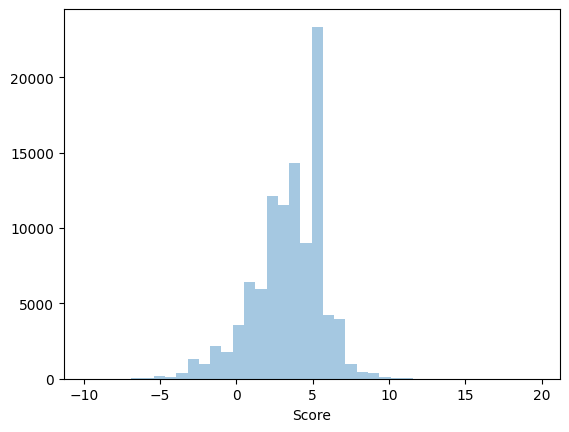

In [204]:
import seaborn as sns
sns.distplot(dfTrain1[(dfTrain1.Score!= 'none') & (dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100)]['Score'], kde=False, bins = 40)

<Axes: xlabel='UpdatedScore'>

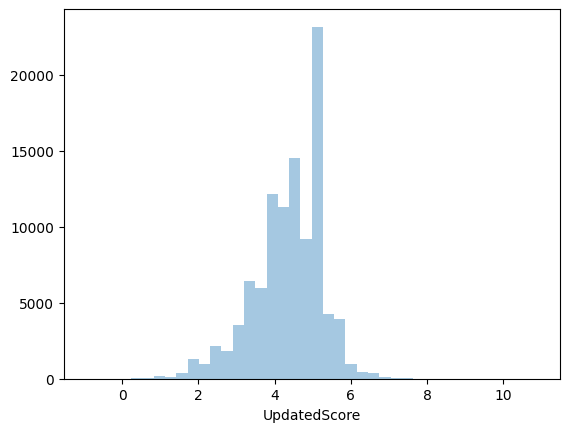

In [205]:
sns.distplot(dfTrain1[(dfTrain1.Score!= 'none') & (dfTrain1.Score!=-300) & (dfTrain1.Score!=-200) & (dfTrain1.Score.notnull()) & (dfTrain1.Score!=-100)]['UpdatedScore'], kde=False, bins = 40)

### Save Sentiment Analysis Results Files

In [206]:
file_name = "Tweets_Spanish_" + mode + ".xlsx"
dfTrain1.to_excel("/sentiment-analysis-results/"+file_name)

In [207]:
print("Output file save successfully..!")

Output file save successfully..!
